In [1]:
from astropy.table import Table
from astropy.io import fits
import pandas as pd
import numpy as np
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.coordinates import SkyCoord

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12


In [3]:
filename='astraAllStarASPCAP-0.6.0.fits'
tb = fits.open(filename)
header=tb[2].header
data = tb[2].data 

In [5]:
print(header)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2068 / length of dimension 1                          NAXIS2  =              1095480 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                  396 / number of table fields                                                                                                                 Metadata                                                                                                                                                INSTRMNT= 'APOGEE  '           / Instrument                                     PIPELINE= 'ASPCAP  '           / Pipelin

In [7]:
# get rid of stars with negative distances
mask_gaia = (data['zgr_plx']>0)

# use skycoord to input information, correct units
c = SkyCoord(ra=data['ra'][mask_gaia]*u.deg, dec=data['dec'][mask_gaia]*u.deg, 
             distance=(data['r_med_geo'][mask_gaia])*u.pc,
             pm_ra_cosdec=data['pmra'][mask_gaia]*u.mas/u.yr, 
             pm_dec=data['pmde'][mask_gaia]*u.mas/u.yr,
            radial_velocity=data['v_rad'][mask_gaia]*u.km/u.s) 

# transform to galactocentric coordinate
# the assumed values are from Schonrich et al 2010, and from Gravity collab 2022
galcen = c.transform_to(coord.Galactocentric(galcen_v_sun=[8, 254, 8] * u.km / u.s, galcen_distance=8.275 * u.kpc))

In [9]:
# Extract the galactic coordinates and motions
x = galcen.x.value
y = galcen.y.value
z = galcen.z.value

vx = galcen.v_x.value
vy = galcen.v_y.value
vz = galcen.v_z.value

#galactocentric radius (either in the disk-R or distance from the galactic center)
R = np.sqrt(x**2+y**2)
rgal = np.sqrt(x**2+y**2+z**2)

In [11]:
#I clipped data table, including the the M/H and alpha/M vectors to the same length as the R and z information first before plotting
data_masked=data[mask_gaia]

In [13]:
leungraw = Table.read("nn_latent_age_dr17(in).csv", format="ascii")
miglioraw = Table.read("APOKASC2_Miglio_2021.txt", format="ascii")

In [15]:
clean = [float(x) if x not in ('--', '----', 'Gyr') else np.nan
         for x in miglioraw['Age']]
miglioraw['Age'] = clean

C:\Users\Colin\AppData\Local\Temp\ipykernel_2808\3125896977.py:1: UserWarning: Warning: converting a masked element to nan.
  clean = [float(x) if x not in ('--', '----', 'Gyr') else np.nan


In [17]:
hasagemiglio=np.where((miglioraw['Age']==miglioraw['Age']) & (miglioraw['Age']>0.0))
miglio=miglioraw[hasagemiglio]
miglio

APOGEE,KIC,Jmag,Hmag,Ksmag,RAdeg,DEdeg,[Fe/H],[alpha/M],Age,Mass,Rad,Dist,Av,evstate,zmax,Ecc,Rperi,Rap,GalR,Galphi,GalZ,vR,vT,vZ,Simbad,_RA,_DE
str20,str8,str6,str6,str6,str8,str7,str5,str5,float64,str5,str5,str6,str6,str1,str6,str6,str6,str6,str6,str6,str6,str7,str6,str7,str6,str9,str9
2M19222920+3710285,1569842,9.589,9.074,8.989,290.6217,37.1746,-0.24,0.12,9.8,1.00,4.98,0.619,0.07,1,0.366,0.112,6.648,8.328,7.933,0.072,0.131,-29.82,209.19,21.51,Simbad,290.62167,+37.17458
2M19300513+3717470,1726291,11.206,10.679,10.547,292.5214,37.2964,-0.34,0.19,10.1,0.98,4.68,1.170,0.43,1,0.310,0.168,7.417,10.420,7.812,0.140,0.204,31.83,245.94,10.69,Simbad,292.52137,+37.29639
2M19045380+3741230,2283721,11.266,10.709,10.590,286.2242,37.6897,-0.19,0.11,9.4,1.01,6.58,1.676,0.30,1,0.493,0.072,6.745,7.798,7.680,0.198,0.415,-16.38,210.65,-16.16,Simbad,286.22417,+37.68972
2M19060736+3740100,2284679,9.923,9.456,9.335,286.5307,37.6694,-0.45,0.21,11.2,0.94,3.98,0.588,0.07,1,0.821,0.844,0.692,8.204,7.934,0.067,0.157,66.53,37.45,-39.19,Simbad,286.53067,+37.66944
2M19280882+3736381,2305590,9.829,9.235,9.128,292.0368,37.6106,-0.30,0.24,10.2,1.03,8.43,1.072,0.34,1,0.529,0.587,2.392,9.188,7.835,0.128,0.197,111.85,114.69,27.80,Simbad,292.03675,+37.61058
2M19250117+3742537,2442483,11.509,10.934,10.812,291.2549,37.7149,-0.14,0.12,10.0,1.02,5.87,1.662,0.37,1,0.338,0.208,5.329,8.135,7.726,0.201,0.312,43.73,189.59,7.28,Simbad,291.25487,+37.71492
2M19261694+3745527,2443903,10.223,9.682,9.588,291.5706,37.7646,-0.54,0.23,12.6,0.92,6.81,1.093,0.17,1,0.553,0.253,5.138,8.617,7.830,0.130,0.208,60.49,186.64,-27.60,Simbad,291.57058,+37.76464
2M19202341+3749231,2568912,11.130,10.600,10.469,290.0975,37.8231,-0.09,0.16,10.4,1.03,5.16,1.244,0.38,1,1.618,0.339,6.382,12.924,7.790,0.148,0.257,91.11,240.72,57.42,Simbad,290.09754,+37.82308
2M19271735+3755229,2714785,10.646,10.151,10.005,291.8223,37.9230,-0.13,0.17,11.0,1.01,5.40,1.059,0.19,1,1.027,0.223,6.017,9.476,7.841,0.126,0.200,64.30,208.47,48.25,Simbad,291.82229,+37.92303


In [19]:
agedata= miglio

In [21]:
intersect, ind_a, ind_b = np.intersect1d(data_masked['sdss4_apogee_id'].data,agedata['APOGEE'].data, return_indices=True)

In [23]:
fullx = np.dstack([data_masked['teff'][ind_a],data_masked['logg'][ind_a], data_masked['m_h_atm'][ind_a],
                   data_masked['alpha_m_atm'][ind_a], data_masked['c_h'][ind_a], data_masked['n_h'][ind_a]])[0]

fully = np.dstack([agedata['Age'][ind_b]])[0] #for Pinsonneault 2018

#remove non-finite entries!
mask = np.all(np.isfinite(fullx), axis=1) & np.all(np.isfinite(fully), axis=1)
fullx, fully = fullx[mask], fully[mask]

scaling_x = np.median(fullx, axis=0)
scaling_y = np.median(fully, axis=0)

fullx, fully = fullx/scaling_x, fully/scaling_y

In [25]:
neurons_per_layer=12
layers=3
iterations=100

In [27]:
#start with an input layer
inputs = keras.Input(shape=(6,))
#now we add the Dense layers (indicating the previous layer in the brackets following the layer declaration

#change this part if you're changing the number of layers
layer1 =keras.layers.Dense(neurons_per_layer, activation='relu')(inputs)
layer2 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer1)
layer3 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer2)
layer4 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer3)
layer5 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer4)
layer6 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer5)
layer7 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer6)
layer8 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer7)
layer9 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer8)
layer10 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer9)
layer11 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer10)
layer12 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer11)
layer13 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer12)
layer14 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer13)
layer15 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer14)
layer16 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer15)
layer17 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer16)
layer18 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer17)
layer19 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer18)
layer20 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer19)
layer21 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer20)
layer22 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer21)
layer23 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer22)

#then the output layer YOU ALSO HAVE TO MAKE THIS MATCH YOUR NUMBER OF LAYERS
outputs = keras.layers.Dense(1)(layer4)


# then we put that all together in the Model object
model = keras.Model(inputs=inputs, outputs=outputs, name='test')
#and we can print a summary to check it all went to plan
model.summary()

Model: "test"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 565 (2.21 KB)

 Trainable params: 565 (2.21 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [33]:
model.fit(x_train, y_train, epochs=iterations, validation_split=0.05, batch_size=300)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 3.5600e-04 - loss: 2.9454 - val_accuracy: 0.0000e+00 - val_loss: 0.8785
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0075 - loss: 0.8478 - val_accuracy: 0.0135 - val_loss: 0.9607
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0082 - loss: 0.8827 - val_accuracy: 0.0068 - val_loss: 0.6931
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0043 - loss: 0.6728 - val_accuracy: 0.0068 - val_loss: 0.7002
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0061 - loss: 0.6359 - val_accuracy: 0.0203 - val_loss: 0.6542
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0089 - loss: 0.5816 - val_accuracy: 0.0203 - val_loss: 0.6005
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0085 - loss: 0.5456 - val_accuracy: 0.0203 - val_loss: 0.5502
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0089 - loss: 0.4912 - val_accuracy: 

In [35]:
predictions = model.predict(x_test)
print(len(predictions))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
328


In [37]:
metric=0.3 #is the accuracy better than 30%?
goodfit=np.where(((1-metric) < predictions/y_test) & ((1+metric) > predictions/y_test)) 
badfit=np.where(((1-metric) > predictions/y_test) | ((1+metric) < predictions/y_test))

print ('With ', neurons_per_layer, 'neurons per layer, ', layers, 'layers, and ', iterations, 'iterations')
print ('using the training set', trainbin)
print (len(goodfit[0])/len(y_test)*100, 'percent of the ages are good')
print (len(badfit[0])/len(y_test)*100, 'percent of the ages are bad')

With  12 neurons per layer,  3 layers, and  100 iterations
using the training set slice(0, -330, None)
68.59756097560977 percent of the ages are good
31.402439024390244 percent of the ages are bad


(0.0, 14.0)

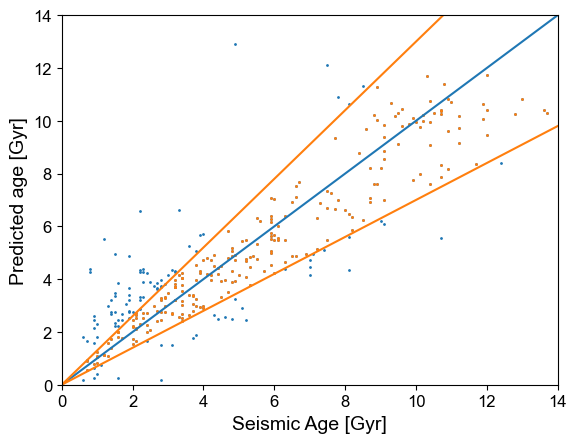

In [39]:
#remember that we scaled our input/output
plt.scatter( (y_test*scaling_y),(predictions*scaling_y), s=1.)
plt.scatter( (y_test[goodfit]*scaling_y),(predictions[goodfit]*scaling_y), s=1.)
plt.xlim(0.,14.)
plt.plot([0.,14.], [0.,14.])
plt.plot([14,0,14], [14*(1-metric), 0, 14*(1+metric)])

plt.ylabel(r'Predicted age [Gyr]')
plt.xlabel(r'Seismic Age [Gyr]')
plt.ylim(0,14)

In [41]:
DR19x = np.dstack([data_masked['teff'],data_masked['logg'], data_masked['m_h_atm'],
                   data_masked['alpha_m_atm'], data_masked['c_h'], data_masked['n_h']])[0]
print(len(data_masked['teff']))

DR19x= DR19x/scaling_x
predictionsDR19 = model.predict(DR19x)

963539
30111/30111 ━━━━━━━━━━━━━━━━━━━━ 21s 692us/step


In [43]:
good=np.where((data_masked['teff'] > 3700) &
    (data_masked['teff'] < 5300) &
    (data_masked['logg'] > 0.9) &
    (data_masked['logg'] < 3.3) &
    (data_masked['m_h_atm'] > -2.0) &
    (data_masked['m_h_atm'] < 0.6)
             )

In [219]:
mil_predic = predictionsDR19[good]

In [221]:
#reducing leung's data to only the "good" data
hasageleung=np.where((leungraw['Age']==leungraw['Age']) & (leungraw['Age']>0.0) & (leungraw['STARFLAG']==0) & (leungraw['ASPCAPFLAG']==0.0))
leung=leungraw[hasageleung]
leung

APOGEE_ID,TELESCOPE,FIELD,STARFLAG,ASPCAPFLAG,z0,z1,z2,z3,z4,Age,Age_Error,LogAge,LogAge_Error
str19,str6,str19,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2M00000068+5710233,apo25m,N7789,0,0.0,0.109830648,2.783815861,0.490213335,0.12969476,0.558128595,3.713865837,1.315107241,0.569826211,0.138561098
2M00000506+5656353,apo25m,NGC7789_btx,0,0.0,-0.244461939,-0.169833854,-0.747379601,-0.047868535,-0.230698362,3.081406594,1.24575715,0.488749008,0.181852592
2M00000644+5733530,apo25m,NGC7789_MGA,0,0.0,-0.279349327,0.020289183,-0.377695978,0.061857868,1.49671495,3.041127945,1.27658013,0.483034692,0.236690977
2M00000866+7122144,apo25m,120+08,0,0.0,-0.218891755,-0.210707322,0.335598797,0.026745249,-0.049675092,6.893997642,2.467813235,0.838471131,0.145866114
2M00000943+6254542,apo25m,116+00,0,0.0,1.070843697,0.019564584,-0.612648726,0.131503895,1.010400772,5.862042235,1.648182947,0.768048943,0.134068978
2M00001071+6258172,apo25m,116+00,0,0.0,0.167497665,-0.767329812,-1.305983305,0.041342232,-0.799106538,2.599209342,1.53599277,0.414841259,0.432229069
2M00001104+6348085,apo25m,117+01,0,0.0,-0.392587274,2.486913204,0.324699759,-0.059271969,0.348974377,4.089179602,1.374298726,0.611636186,0.135857224
2M00001296+5851378,apo25m,116-04,0,0.0,-0.864830136,0.355200082,-0.505398095,0.214336187,0.278642505,6.304886225,2.076918307,0.799677254,0.164960385
2M00002141+8606336,apo25m,N188,0,0.0,0.236360759,2.17316556,0.84574914,-0.332254648,1.033923984,6.256571049,2.679627389,0.796336381,0.165056883


In [223]:
from astropy.table import unique

In [225]:
t = Table()

t['APOGEE'] = data_masked['sdss4_apogee_id'][good]
t['Age'] = mil_predic

In [227]:
overlap = np.intersect1d(leung['APOGEE_ID'].data, t['APOGEE'].data)
leung_temp = leung[np.isin(leung['APOGEE_ID'].data, overlap)]
leung_reduced = unique(leung_temp, keys = 'APOGEE_ID')
predic_temp= t[np.isin(t['APOGEE'].data, overlap)]
predic_reduced = unique(predic_temp, keys = 'APOGEE')

In [228]:
l_sort = leung_reduced.copy()
l_sort.sort(['APOGEE_ID'])
p_sort = predic_reduced.copy()
p_sort.sort(['APOGEE'])

In [231]:
p_sort['Age'] = p_sort['Age'].reshape(-1)

In [279]:
d_age = p_sort['Age'] - l_sort['LogAge']

Text(0, 0.5, 'Δ Age [Gyr]')

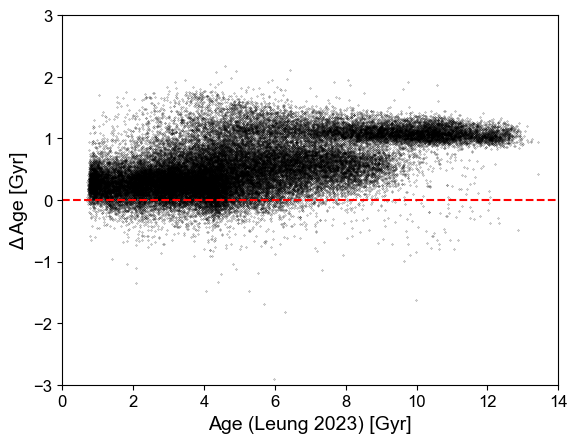

In [303]:
plt.figure()
plt.scatter(l_sort['Age'], d_age, s=0.05, color = 'black', alpha=0.8)
plt.plot([0, 14], [0, 0], linestyle = '--', color = 'red')
plt.xlim(0, 14)
plt.ylim(-3, 3)
plt.xlabel('Age (Leung 2023) [Gyr]')
plt.ylabel('Δ Age [Gyr]')